In [4]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [78]:
class NomalDist:
    def __init__(self, mu, sigma):
        self.d = mu.size
        sigma_cho = np.linalg.cholesky(sigma)
        self.mu = Variable(torch.from_numpy(mu).float())
        self.sigma = Variable(torch.from_numpy(sigma).float())
        self.sigma_inv = torch.inverse(self.sigma)
        self.sigma_cho = Variable(torch.from_numpy(sigma_cho).float())
        
    def loss(self, x):
        return torch.matmul(torch.transpose(x - self.mu[:, None], 0, 1), 
                            torch.matmul(self.sigma_inv, (x - self.mu[:, None])))
    
    def sample(self, n_samples):
        z = Variable(torch.randn((n_samples, self.d)).float())
        samples = torch.transpose(torch.matmul(self.sigma_cho, torch.transpose(z, 0, 1)), 0, 1)
        samples += self.mu[None, :] 
        return samples.data.numpy()

Example samples

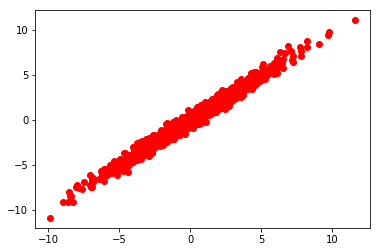

In [123]:
mu = np.zeros([2], dtype=float)
sigma = np.array([[10, 9.9], [9.9, 10]])
dist = NomalDist(mu, sigma)
samples = dist.sample(1000)
plt.plot(samples[:, 0], samples[:, 1], 'ro')

In [124]:
class SGHMC:
    
    def __init__(self, var, alpha, eta, log_density):
        """
        Stochastic Gradient Monte Carlo sampler.
        
        Args:
            var: `Variable` corresponding to the variable that is sampled
            alpha: momentum parameter
            eta: learning rate parameter
            log_density: function computing log_density for a given sample
                and batch of data
        """
        self.var = var
        self.alpha = alpha
        self.eta = eta
        self.log_density = log_density
        self.optimizer = optim.SGD([self.var], lr=1, momentum=(1 - self.alpha))
    
    def _noise(self):
        std = np.sqrt(2 * self.alpha * self.eta)
        n = Variable(torch.normal(0, std= std * torch.ones(self.var.size())))
        return torch.sum(n * self.var)
        
    def sample(self):
        loss = self.log_density(self.var) * self.eta
        loss += self._noise()
        loss.backward()
        self.optimizer.step()
        self.var.grad.data.zero_()
        return self.var

In [125]:
x = torch.from_numpy(np.array([[-10], [0]])).float()
x_v = Variable(x, requires_grad=True)
mu = np.zeros([2], dtype=float)
sigma = np.array([[10, 9.9], [9.9, 10]])
dist = NomalDist(mu, sigma)
sghmc = SGHMC(x_v, .01, 5e-3, dist.loss)

In [126]:
samples = []
for epoch in range(10000):
    w_sample = sghmc.sample()
    samples.append(np.copy(w_sample.data.numpy()).T)
    if not(epoch % 100):
        print(epoch)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [128]:
samples = np.vstack(samples)
samples.shape

(10000, 2)

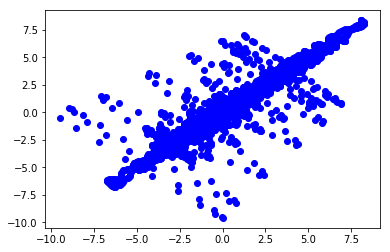

In [129]:
start_from=0
plus = 10000
plt.plot(samples[start_from:start_from+plus, 0], samples[start_from:start_from+plus, 1], 'bo')

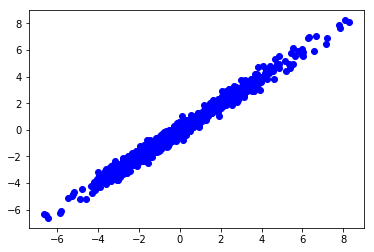

In [130]:
freq = 10
new_samples = []
for i in range(int(samples.shape[0] / freq))[100:]:#[400:]:
    new_samples.append(samples[i * freq][None, :])
new_samples = np.vstack(new_samples)
plt.plot(new_samples[:, 0], new_samples[:, 1], 'bo')
